# OCR model conversion from gpu to cpu

In [30]:
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import InputLayer, Flatten, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

## Making an OCR model

In [2]:
mnist =  tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()

In [3]:
x_train,x_test = x_train/255.0,x_test/255.0

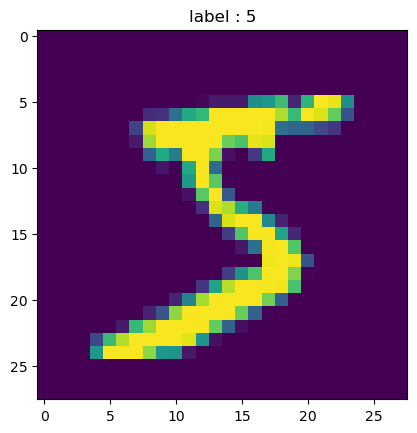

In [4]:
plt.imshow(x_train[0])
plt.title(f'label : {y_train[0]}')
plt.show()

In [5]:
model = Sequential()
model.add(InputLayer(shape=(28,28)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10,activation='softmax'))

In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [8]:
with tf.device('/GPU:0'):
    model.fit(x_train,y_train,epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8546 - loss: 0.4900
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9542 - loss: 0.1578
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9682 - loss: 0.1079
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9720 - loss: 0.0887
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9763 - loss: 0.0759
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9797 - loss: 0.0623
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9823 - loss: 0.0572
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9826 - loss: 0.0525
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9858 - loss: 0.0444
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9865 - loss: 0.0401


In [9]:
model.save('Desktop/deep_learning/mnist_ocr_model_gpu.keras')

In [10]:
model = load_model('Desktop/deep_learning/mnist_ocr_model_gpu.keras')

## Conversion between GPU and CPU model 

In [11]:
def process_video(path,device='/CPU:0'):
    cp = cv2.VideoCapture(path)
    frame_count = 0
    total_latency = 0
    start_time = time.time()
    max_duration = 10 
    with tf.device(device):
        while cp.isOpened():
            ret, frame = cp.read()
            if not ret:
                break
                
            gray_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)            
            resized_frame = cv2.resize(gray_frame,(28,28))            
            normalized_frame = resized_frame/255.0            
            input_frame = np.expand_dims(normalized_frame, axis = 0)
            input_frame = np.expand_dims(input_frame, axis =-1)
            
            pred_start_time = time.time()
            pred = model.predict(input_frame)
            pred_label = np.argmax(pred)
            pred_end_time = time.time()
            latency = pred_end_time - pred_start_time
            total_latency += latency
            
            cv2.putText(frame,f' Label: {pred_label}', (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            cv2.imshow(f'video on {device}',frame)
            
            if time.time() - start_time > max_duration:
                break
            
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
                
            frame_count +=1
    end_time = time.time()
    cp.release()
    cv2.destroyAllWindows()

    total_time = end_time - start_time
    fps = frame_count / total_time
    average_latency = total_latency / frame_count if frame_count > 0 else 0
    print(f"Processed {frame_count} frames on {device} in {total_time:.2f} seconds.")
    print(f"FPS on {device}: {fps:.2f}")
    print(f"Average Latency on {device}: {average_latency:.4f} seconds")

In [12]:
path = r'C:\Users\santosh\Videos\Captures\Zoom Meeting 2024-06-29 11-16-00.mp4'

In [13]:
print("Running on CPU...")
process_video(path, device='/CPU:0')

Running on CPU...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [14]:
print("Running on GPU...")
process_video(path, device='/GPU:0')

Running on GPU...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/s

## Comparitive analysis of GPU and CPU model

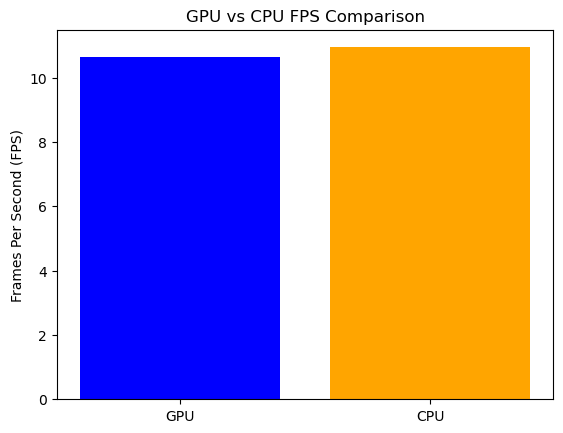

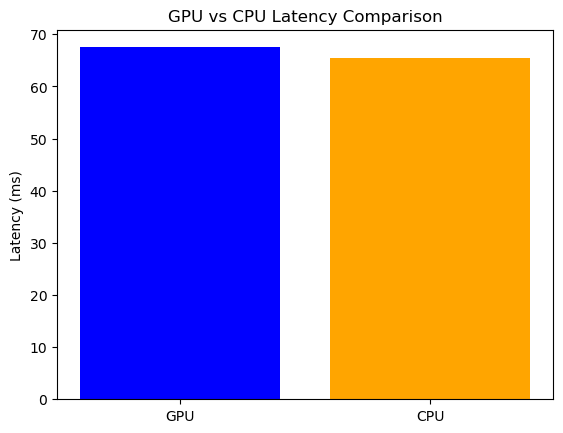

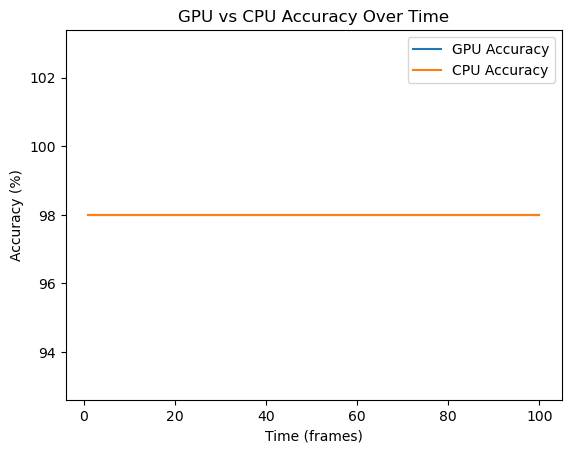

In [15]:

gpu_fps = 10.63  
cpu_fps = 10.94  
gpu_latency = 0.0675  
cpu_latency = 0.0655  
accuracy = 98  

plt.bar(['GPU', 'CPU'], [gpu_fps, cpu_fps], color=['blue', 'orange'])
plt.title('GPU vs CPU FPS Comparison')
plt.ylabel('Frames Per Second (FPS)')
plt.show()

plt.bar(['GPU', 'CPU'], [gpu_latency * 1000, cpu_latency * 1000], color=['blue', 'orange'])
plt.title('GPU vs CPU Latency Comparison')
plt.ylabel('Latency (ms)')
plt.show()

time = range(1, 101)
accuracy_gpu = [accuracy] * 100
accuracy_cpu = [accuracy] * 100
plt.plot(time, accuracy_gpu, label='GPU Accuracy')
plt.plot(time, accuracy_cpu, label='CPU Accuracy')
plt.title('GPU vs CPU Accuracy Over Time')
plt.xlabel('Time (frames)')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


## technique for optimization of OCR models for CPU 

In [21]:
from keras.applications import MobileNet
from keras.utils import Sequence

In [22]:
mnist =  tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()

x_train = np.stack([x_train]*3, axis=-1)
x_test = np.stack([x_test]*3, axis=-1)

In [23]:
class MNISTDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size=32, image_size=(224, 224)):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        resized_batch_x = np.array([cv2.resize(img, self.image_size) for img in batch_x])
        resized_batch_x = resized_batch_x / 255.0 

        return resized_batch_x, batch_y

In [24]:
train_generator = MNISTDataGenerator(x_train, y_train, batch_size=32)
test_generator = MNISTDataGenerator(x_test, y_test, batch_size=32)

In [25]:
base_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

In [26]:
model = Sequential([base_model,
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dropout(0.2),
                    Dense(10, activation='softmax')]) 

In [27]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ ?                           │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [29]:
model.fit(train_generator, validation_data=test_generator, epochs=5)

Epoch 1/5


C:\Users\santosh\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1094s 582ms/step - accuracy: 0.9157 - loss: 0.4129 - val_accuracy: 0.9810 - val_loss: 0.0735
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1088s 580ms/step - accuracy: 0.9682 - loss: 0.1078 - val_accuracy: 0.9849 - val_loss: 0.0799
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1073s 572ms/step - accuracy: 0.9772 - loss: 0.0838 - val_accuracy: 0.9887 - val_loss: 0.0491
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1074s 573ms/step - accuracy: 0.9794 - loss: 0.0693 - val_accuracy: 0.9898 - val_loss: 0.0541
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1076s 574ms/step - accuracy: 0.9816 - loss: 0.0642 - val_accuracy: 0.9883 - val_loss: 0.0573


In [36]:
def process_video(path,device='/CPU:0'):
    cp = cv2.VideoCapture(path)
    frame_count = 0
    total_latency = 0
    start_time = time.time()
    max_duration = 10 
    with tf.device(device):
        while cp.isOpened():
            ret, frame = cp.read()
            if not ret:
                break
                
            rgb_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)            
            resized_frame = cv2.resize(rgb_frame,(224,224))            
            normalized_frame = resized_frame/255.0            
            input_frame = np.expand_dims(normalized_frame, axis = 0)
            input_frame = np.expand_dims(input_frame, axis =-1)
            
            pred_start_time = time.time()
            pred = model.predict(input_frame)
            pred_label = np.argmax(pred)
            pred_end_time = time.time()
            latency = pred_end_time - pred_start_time
            total_latency += latency
            
            cv2.putText(frame,f' Label: {pred_label}', (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            cv2.imshow(f'video on {device}',frame)
            
            if time.time() - start_time > max_duration:
                break
            
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
                
            frame_count +=1
    end_time = time.time()
    cp.release()
    cv2.destroyAllWindows()

    total_time = end_time - start_time
    fps = frame_count / total_time
    average_latency = total_latency / frame_count if frame_count > 0 else 0
    print(f"Processed {frame_count} frames on {device} in {total_time:.2f} seconds.")
    print(f"FPS on {device}: {fps:.2f}")
    print(f"Average Latency on {device}: {average_latency:.4f} seconds")

In [37]:
print("Running on CPU...")
process_video(path, device='/CPU:0')

Running on CPU...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47m

In [38]:
print("Running on GPU...")
process_video(path, device='/GPU:0')

Running on GPU...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms

# Challenges 

In [39]:
# reduced FPS
# Accuracy degradation
# latency issues

# Solution 

In [ ]:
# Use quantization-aware training to maintain accuracy
# Use knowledge distillation, where a smaller CPU-friendly model is trained to mimic a larger.
# Implement multi-threading or asynchronous processing to better utilize CPU cores, reducing latency.